# Infection régionale française avec le nouveau coronavirus (SARS-CoV-2), COVID-19

Sante Publique France fournit les taux quotidiens [confirmés d'infection](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde) au niveau régional. Toutefois, ces taux sont fournis sous la forme d'un tableau statique unique sans historique.

Le 26 mars 2020, la publication des données a été modifiée et cette série chronologique a été mise à jour. C'est toujours un travail en cours, et les données sur les infections confirmées sont très bizarres.

Je les ai compilés en une série chronologique et je vais essayer de les tenir à jour pendant la pandémie. N'hésitez pas à les utiliser comme vous le souhaitez. Code publié sous licence BSD-3 et tout le reste comme CC-By.

Shapefiles de [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/contours-geographiques-des-nouvelles-regions-metropole/).

Data: [Chiffres-clés concernant l'épidémie de COVID19 en France](https://www.data.gouv.fr/en/datasets/chiffres-cles-concernant-lepidemie-de-covid19-en-france/)

Exigences: Pandas, Matplotlib, GeoPandas, GeoPlot

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from datetime import datetime
from matplotlib import pyplot as plt
import math
from datetime import datetime, timedelta
from tabulate import tabulate
import seaborn as sns
import urllib.request

def doubling_time(x, y, z):
    """
    x est le temps qui s'est écoulé depuis que vous avez commencé à mesurer. 
        Par exemple, si le nombre de cas est passé de 500 le jour 0 à 1000 le jour 2, x est égal à 2.
    y est le nombre de cas au jour x, par exemple 1000 au jour 2.
    z est le nombre de cas au jour 0, par exemple 500.
    """
    return (x*math.log(2))/(math.log(y/z))

url = "https://www.data.gouv.fr/en/datasets/r/0b66ca39-1623-4d9c-83ad-5434b7f9e2a4"
data_file = "data/chiffres-cles.csv"
urllib.request.urlretrieve(url, data_file)

('data/chiffres-cles.csv', <http.client.HTTPMessage at 0x1f8188fb828>)

In [2]:
df = pd.read_csv(data_file)
df = df[df["granularite"]=="region"]
for c in ["granularite", "maille_code", "source_nom", "source_url", "source_archive", "source_type"]:
    del df[c]
# Filtrer par date limite
latest_date = df["date"].max()
df = df.groupby(["maille_nom", "date"]).mean().fillna(0).reset_index()
df = df.rename(columns={
    "maille_nom": "Région", 
    "cas_confirmes": "Cumulatif-cas-confirmés",
    "hospitalises": "Hospitalisées",
    "reanimation": "Réanimation",
    "deces": "Cumulatif-décédées",
    "gueris": "Cumulatif-guéries",
    "depistes": "Cumulatif-dépistées",
    "date": "Date"  
})
new_types = {c: "int32" for c in ["Cumulatif-cas-confirmés","Hospitalisées",
                                  "Réanimation","Cumulatif-décédées",
                                  "Cumulatif-guéries","Cumulatif-dépistées"]}
df = df.astype(new_types)
for column in ["Hospitalisées", "Réanimation"]:
    df[F"Cumulatif-{column.lower()}"] = df.groupby("Région")[column].cumsum()
new_columns = {
    "Cumulatif-cas-confirmés": "Cas-confirmés",
    "Cumulatif-décédées": "Décédées",
    "Cumulatif-guéries": "Guéries",
    "Cumulatif-dépistées": "Dépistées"
}
for c, nc in new_columns.items():
    # https://stackoverflow.com/a/48348006
    df[nc] = df.groupby(["Région"])[c].diff().fillna(df[c])
df["Date"] = pd.to_datetime(df.Date)
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
shape_data = gpd.GeoDataFrame.from_file("data/contours-geographiques-des-nouvelles-regions-metropole.shp")
regions = {"Grand-Est": "Grand Est",
           "Bourgogne-Franche-ComtÃ©": "Bourgogne-Franche-Comté", 
           "Auvergne-RhÃ´ne-Alpes": "Auvergne-Rhône-Alpes", 
           "Provence-Alpes-CÃ´te d'Azur": "Provence-Alpes-Côte d'Azur", 
           "Nouvelle Aquitaine": "Nouvelle-Aquitaine",
           "Ile-de-France": "Île-de-France"
          }
shape_data["region"] = shape_data["region"].replace(regions)

df[df["Date"] == latest_date]

,Région,Date,Cumulatif-cas-confirmés,Cumulatif-décédées,Réanimation,Hospitalisées,Cumulatif-guéries,Cumulatif-dépistées,Cumulatif-hospitalisées,Cumulatif-réanimation,Cas-confirmés,Décédées,Guéries,Dépistées
32,Auvergne-Rhône-Alpes,2020-03-26,0,134,290,1422,496,0,6763,1294,-2093.0,29.0,92.0,0.0
60,Bourgogne-Franche-Comté,2020-03-26,0,123,166,649,401,0,3683,1018,-1569.0,21.0,57.0,0.0
86,Bretagne,2020-03-26,0,29,45,202,114,0,1082,275,-603.0,1.0,14.0,0.0
111,Centre-Val de Loire,2020-03-26,645,20,68,198,50,0,858,269,84.0,7.0,14.0,0.0
136,Corse,2020-03-26,250,20,11,71,63,0,435,93,21.0,5.0,9.0,0.0
163,Grand Est,2020-03-26,0,584,636,2979,960,0,17415,3872,-5479.0,79.0,189.0,0.0
187,Guadeloupe,2020-03-26,0,0,7,21,4,0,91,39,-76.0,0.0,4.0,0.0
211,Guyane,2020-03-26,31,0,0,0,5,0,0,0,3.0,0.0,0.0,0.0
237,Hauts-de-France,2020-03-26,1910,148,271,919,360,0,5119,1536,157.0,19.0,73.0,0.0
261,La Réunion,2020-03-26,0,0,3,3,0,0,21,21,-94.0,0.0,0.0,0.0


## Carte des points

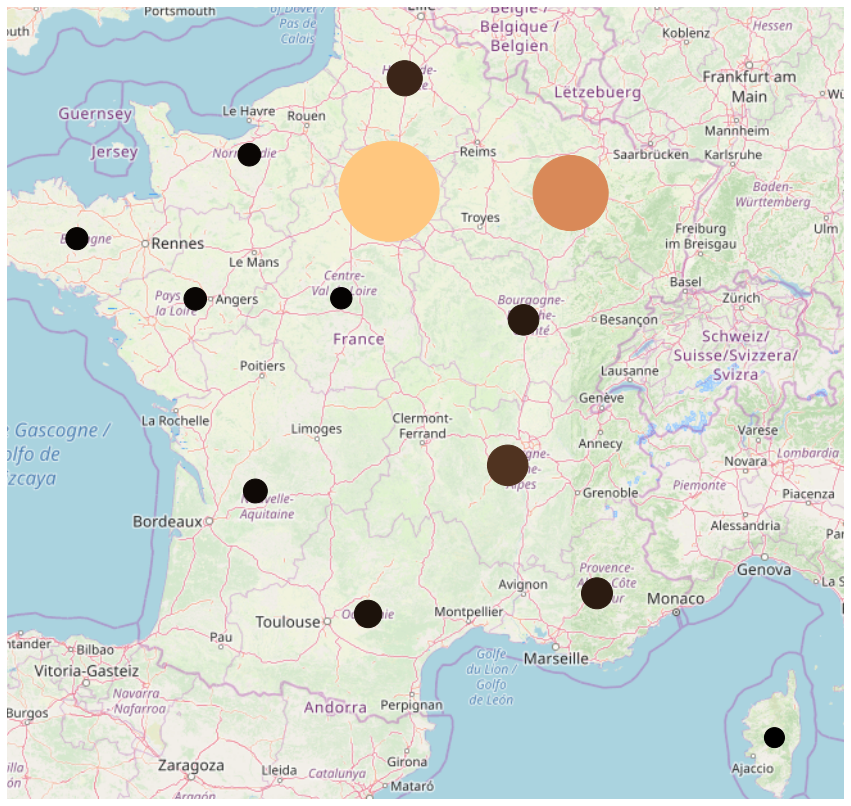

In [3]:
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]

centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]

ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cumulatif-hospitalisées", limits=(20, 100),
               hue="Cumulatif-hospitalisées", cmap="copper",
               ax=ax)

## Graphiques linéaires

Text(0.5, 0.98, 'Régional France COVID-19 cumulatif hospitalisées depuis 2020-03-26')

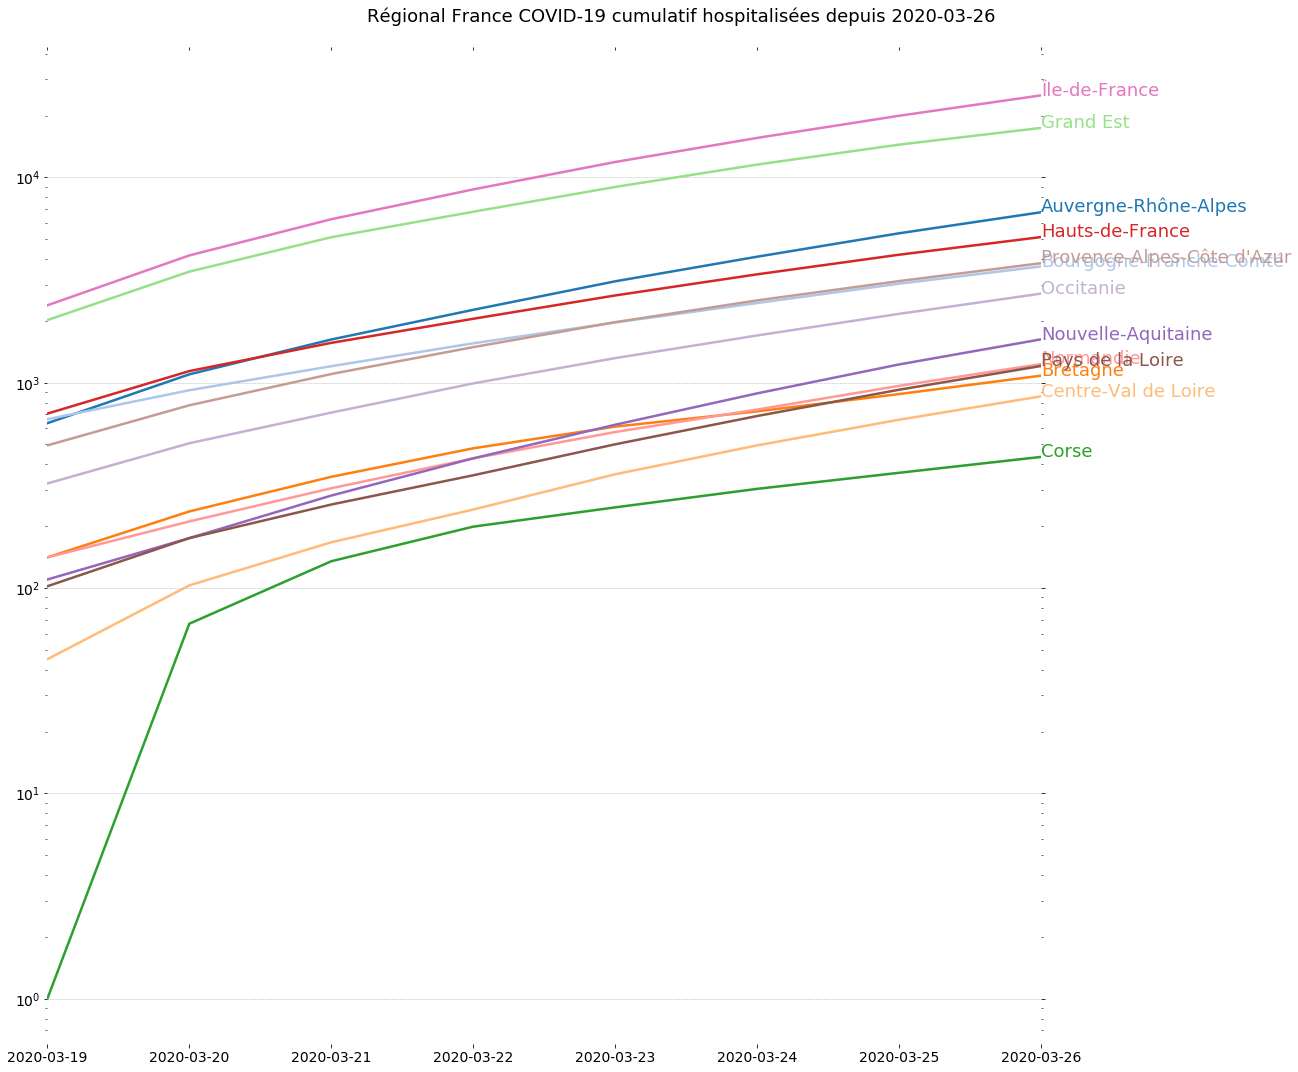

In [4]:
# https://stackoverflow.com/a/29370182
start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
data_min = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-hospitalisées"].min(),-1))
data_max = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-hospitalisées"].max(),-1))
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                         values="Cumulatif-hospitalisées",
                         index=["Date"],
                         columns=["Région"])
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.min().date(), drawing.index.max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, column in enumerate(drawing.columns):
    line = plt.plot(drawing.index,
                    drawing[column],
                    lw=2.5,
                    color=color_sequence[n])
    y_pos = drawing[column][-1] - 0.05
    plt.text(drawing.index.max().date(), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"Régional France COVID-19 cumulatif hospitalisées depuis {drawing.index.max().date().isoformat()}"
fig.suptitle(title, fontsize=18, ha='center')

## Région infection doublant le temps

Référence : [Lisa Charlotte Rost, DataWrapper](https://blog.datawrapper.de/weekly-chart-coronavirus-doublingtimes/)

In [5]:
N = 3
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-hospitalisées"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-hospitalisées"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-hospitalisées"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-hospitalisées"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
    
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

╒════════════════════════════╤═════════════════╤══════════╤════════╤═══════════════╤══════════╤════════╕
│ Région                     │   t. dbler (3j) │   3j av. │ chg.   │ n. cas (3j)   │ 3j av.   │ chg.   │
╞════════════════════════════╪═════════════════╪══════════╪════════╪═══════════════╪══════════╪════════╡
│ Auvergne-Rhône-Alpes       │            2.68 │     1.99 │ ▲      │ 3,646         │ 2,019    │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bourgogne-Franche-Comté    │            3.31 │     2.74 │ ▲      │ 1,718         │ 1,046    │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bretagne                   │            3.64 │     2.19 │ ▲▲     │ 471           │ 375      │ ▲      │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Centre-Val de Loire        │            2.38 │     1.

In [6]:
N = 3
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-cas-confirmés"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
    
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

ValueError: math domain error

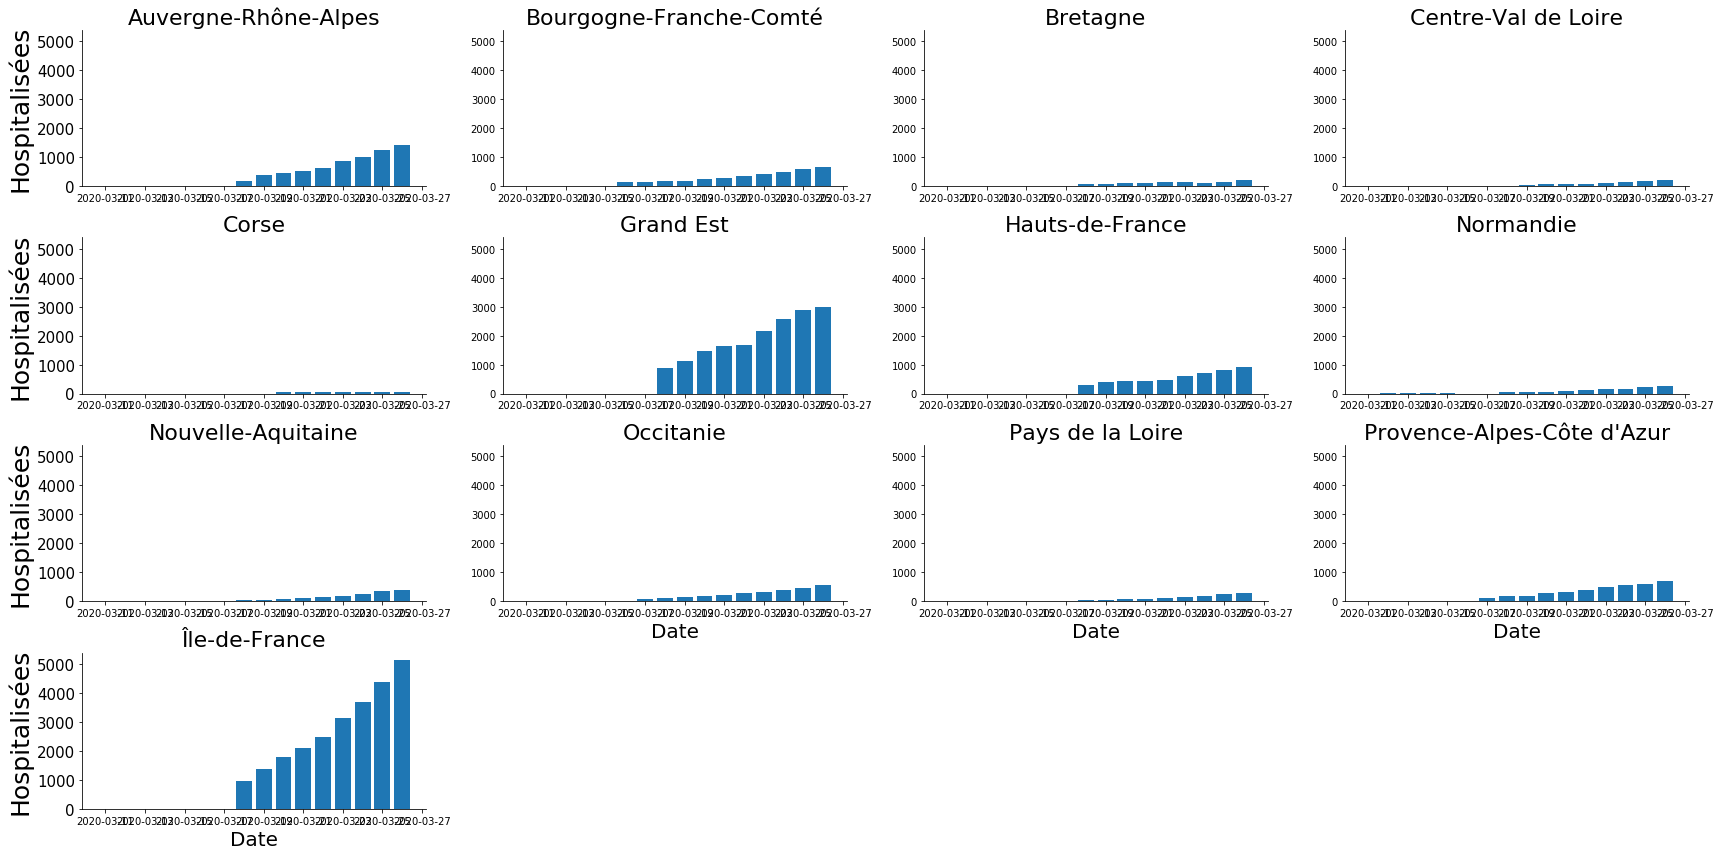

In [7]:
# https://stackoverflow.com/a/54031113
import warnings
warnings.filterwarnings('ignore')

start_date = datetime.strptime("2020-03-10", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)

sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
sm = sm.map(plt.bar, "Date", "Hospitalisées")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

## Cumulé de personnes décédées

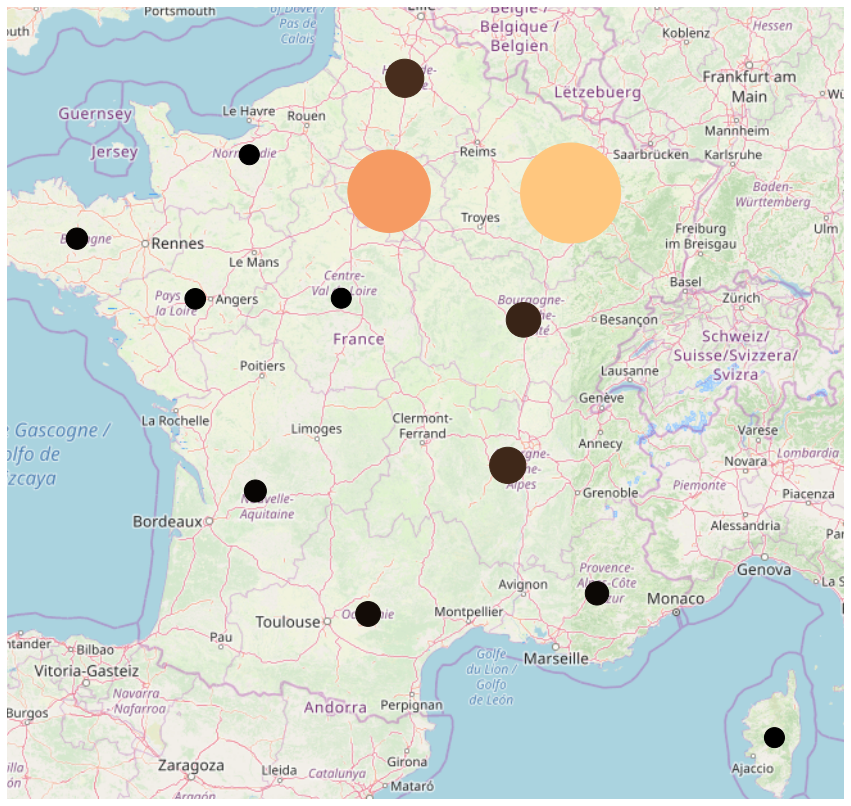

In [8]:
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]

centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]

ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cumulatif-décédées", limits=(20, 100),
               hue="Cumulatif-décédées", cmap="copper",
               ax=ax)

Text(0.5, 0.98, 'Régional France COVID-19 nombre cumulé de personnes décédées depuis 2020-03-26')

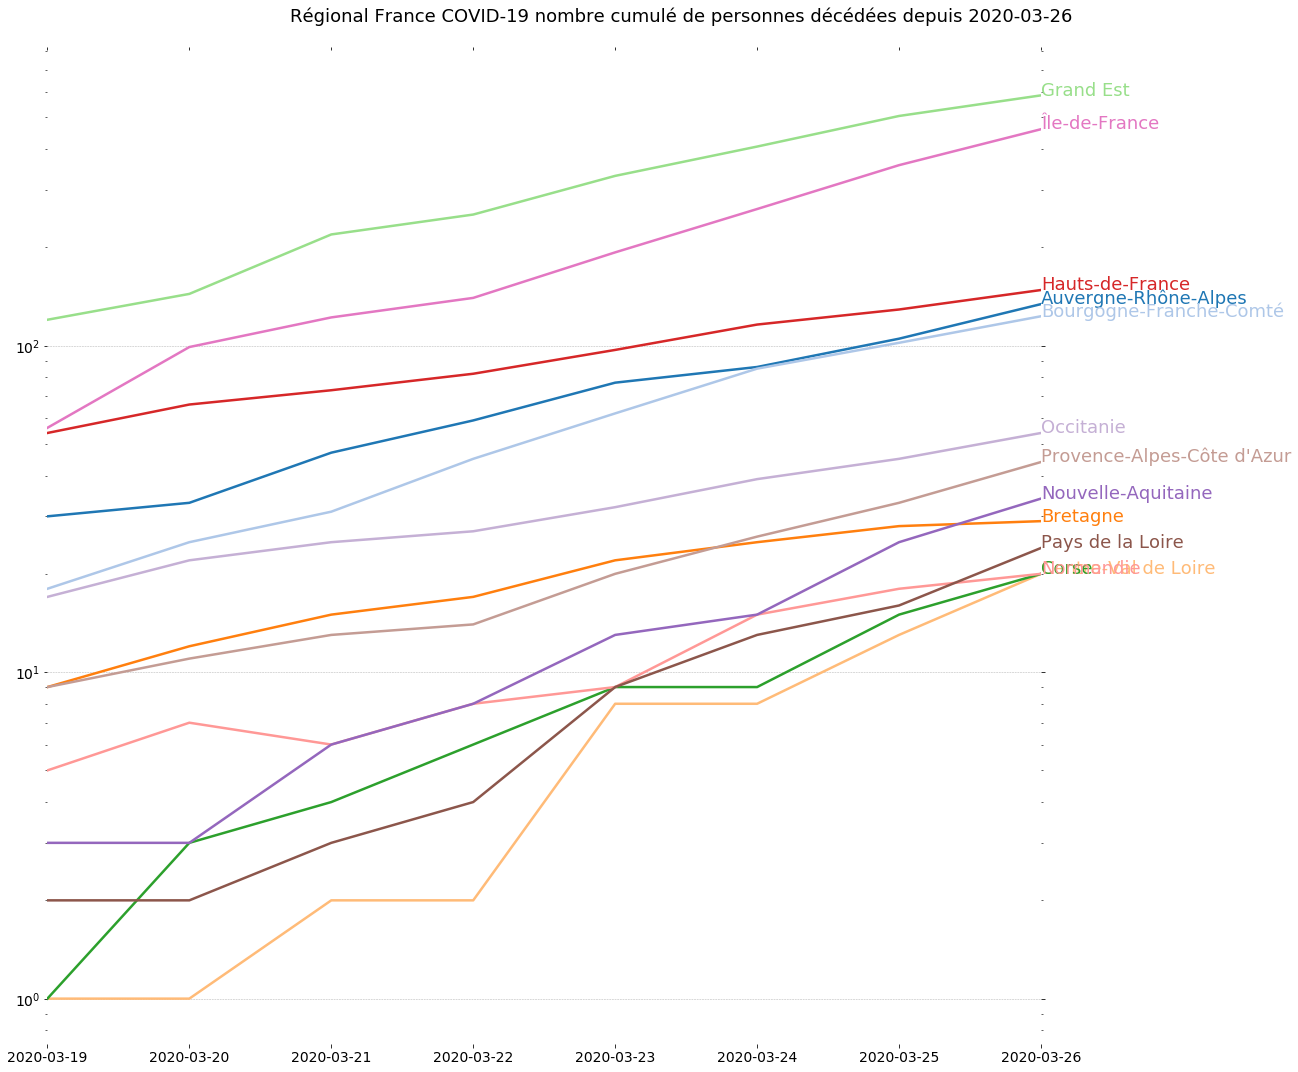

In [9]:
# https://matplotlib.org/examples/showcase/bachelors_degrees_by_gender.html
start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
data_min = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-décédées"].min(),-1))
data_max = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-décédées"].max(),-1))
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                         values="Cumulatif-décédées",
                         index=["Date"],
                         columns=["Région"])
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.min().date(), drawing.index.max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, column in enumerate(drawing.columns):
    line = plt.plot(drawing.index,
                    drawing[column],
                    lw=2.5,
                    color=color_sequence[n])
    y_pos = drawing[column][-1] - 0.05
    plt.text(drawing.index.max().date(), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"Régional France COVID-19 nombre cumulé de personnes décédées depuis {drawing.index.max().date().isoformat()}"
fig.suptitle(title, fontsize=18, ha='center')

In [10]:
N = 3
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-décédées"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-décédées"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-décédées"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-décédées"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

╒════════════════════════════╤═════════════════╤══════════╤════════╤═══════════════╤══════════╤════════╕
│ Région                     │   t. dbler (3j) │   3j av. │ chg.   │   n. cas (3j) │   3j av. │ chg.   │
╞════════════════════════════╪═════════════════╪══════════╪════════╪═══════════════╪══════════╪════════╡
│ Auvergne-Rhône-Alpes       │            3.75 │     2.45 │ ▲▲     │            57 │       44 │ ▲      │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bourgogne-Franche-Comté    │            3.04 │     2.29 │ ▲      │            61 │       37 │ ▲▲     │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Bretagne                   │            7.53 │     3.43 │ ▲▲     │             7 │       10 │ ▼      │
├────────────────────────────┼─────────────────┼──────────┼────────┼───────────────┼──────────┼────────┤
│ Centre-Val de Loire        │            2.27 │     1 

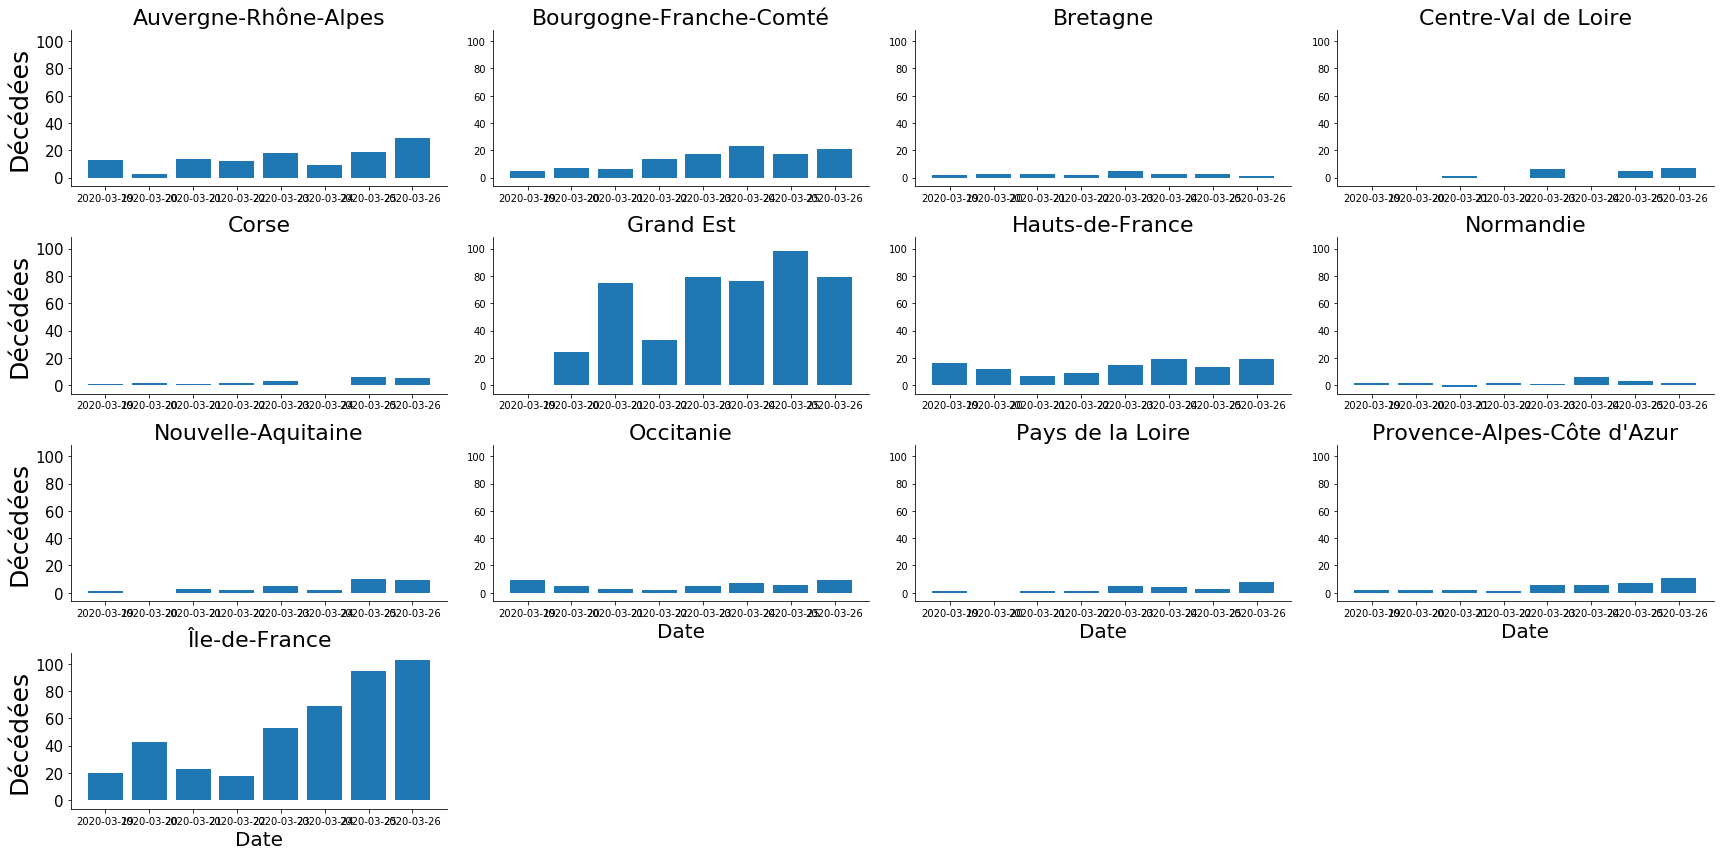

In [11]:
# https://stackoverflow.com/a/54031113
import warnings
warnings.filterwarnings('ignore')

start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
    
sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
sm = sm.map(plt.bar, "Date", "Décédées")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

## Choroplèthe & expériences 

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
boundaries.plot(ax=ax, column="Cas-confirmés", cmap="OrRd")

In [ ]:
# https://stackoverflow.com/a/54031113
import warnings
warnings.filterwarnings('ignore')

def facetgrid_two_axes(*args, **kwargs):
    data = kwargs.pop("data")
    dual_axis = kwargs.pop("dual_axis")
    alpha = kwargs.pop("alpha", 0.2)
    kwargs.pop("color")
    ax = plt.gca()
    if dual_axis:
        ax2 = ax.twinx()
        ax2.set_ylabel("Cumulatif-cas-confirmés")
    # https://github.com/matplotlib/matplotlib/issues/13142/#issuecomment-453174700
    ax.bar(data["Date"], data["Cas-confirmés"], **kwargs, color='red',alpha=alpha,
           width=np.timedelta64(12, 'h'))
    if dual_axis:
        ax2.plot(data["Date"], data["Cumulatif-cas-confirmés"], **kwargs, color='blue',alpha=alpha)
        
sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
#sm = sm.map(plt.bar, "Date", "Cas-confirmés")
#sm = sm.map(plt.plot, "Date", "Cumulatif-cas-confirmés").set(yscale ='log')
sm = sm.map_dataframe(facetgrid_two_axes, dual_axis=True)\
       .set_axis_labels("Date", "Cas-confirmés")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

population_file = "data/France-population.csv"
pf = pd.read_csv(population_file)
chunks = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    d = pf[pf["Région"]==name]["Population"].values[0] / 1000
    region.loc[:, "Cumulatif-cas-confirmés"] = region.apply(lambda x: x["Cumulatif-cas-confirmés"]/d, 
                                                            axis=1)
    chunks.append(region)
pf = pd.concat(chunks)
drawing = pd.pivot_table(pf,
                         values="Cumulatif-cas-confirmés",
                         index=["Date"],
                         columns=["Région"])
fig, ax = plt.subplots(figsize=(20,15))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.set_ylabel("Cumulatif Cas-confirmés / mille", size=25)
ax.set_xlabel("Date", size=20)
drawing.plot(grid=True, logy=True, fontsize=14, ax=ax)
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, fontsize=14, title_fontsize="large")

In [ ]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

dfs = df[df["Région"].isin(boundaries["Région"])].copy()

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(dfs, row="Région", hue="Région", aspect=8, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Cas-confirmés", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "Cas-confirmés", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, size=25,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Cas-confirmés")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[]).set_xlabels(size=20).set_xticklabels(size=15)
g.despine(bottom=True, left=True)